In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection, EllipseCollection
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import constants  # мои константы
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import scipy.linalg
import subprocess as sb
import decimal
from tqdm import tqdm

In [2]:
# загрузка необходимых тестовых данных
with open("trajectory.npy", 'rb') as f:
    res = np.load(f)

with open("rinf.npy", 'rb') as f:
    rinf = np.load(f)

with open("M.npy", 'rb') as f:
    M = np.load(f)

with open("time_points.npy", 'rb') as f:
    t_eval = np.load(f)

with open("enter_index.npy", 'rb') as f:
    ind = np.load(f)

e1 = M[0, :]
e2 = M[1, :]
e3 = M[2, :]

Rinf = rinf[:3]
Vinf = rinf[3:]

In [3]:
B = np.array([Rinf[0], Rinf[1], 0])
C = np.cross(Rinf, Vinf)
c = np.linalg.norm(C)
h = np.linalg.norm(Vinf)**2 - 2 * constants.muL / np.linalg.norm(Rinf)

e = np.sqrt(1 + h * c**2 / constants.muL**2)
p = c**2 / constants.muL
rp = p / (e + 1)

## Вопрос построения эллипса рассеивания
Для того, что бы понимать, как влияют ошибки измерения фазового вектора на конечное положение и на какие орбиты можно попасть с помощью коррекции, необходимо построить два эллипса на картинной плоскости. Строить эти эллипсы буду в линейном приближении:  
$$\Delta\textbf{B}=\textbf{M}\Delta\textbf{r}\\\Delta\textbf{x}=\frac{\partial{\textbf{x}}}{\partial{\textbf{x}_{0}^{T}}}\Delta\textbf{x}_{0}$$  
Где **M** - матрица поворота (не меняется) из начальной СК в СК, связанную с картинной плоскостью, **x** - фазовый вектор, а **x**<sub>0</sub> - начальные условия. Чтобы найти матрицу производных необходимо решить задачу Коши:  
$$\textbf{Ф}=\frac{\partial{\textbf{x}}}{\partial{\textbf{x}_{0}^{T}}}\\\dot{\textbf{Ф}}=\frac{\partial{\textbf{F}}}{\partial{\textbf{x}^{T}}}(\textbf{x}_{ref}(t), t)\:\textbf{Ф}\\\textbf{Ф}(0)=\textbf{E}$$  
Где **x**<sub>ref</sub>(t) это решение системы:  
$$\dot{\textbf{x}}=\textbf{F}(\textbf{x}, t)\\\textbf{x}(0)=\textbf{x}_{0ref}$$
Начнём с решения задачи Коши

### Обезразмеривание задачи
$$
\textbf{x} =  
\begin{pmatrix}
x\\
y\\
z\\
v_x\\
v_y\\
v_z
\end{pmatrix}
=
\begin{pmatrix}
x'*p_0\\
y'*p_0\\
z'*p_0\\
Vx'*v_0\\
Vy'*v_0\\
Vz'*v_0
\end{pmatrix}
=
\textbf{W}\;\textbf{x'}\\
where\:\textbf{W}=  
\begin{pmatrix}
p_0 &0 &0 &0 &0 &0\\
0 &p_0 &0 &0 &0 &0\\
0 &0 &p_0 &0 &0 &0\\
0 &0 &0 &v_0 &0 &0\\
0 &0 &0 &0 &v_0 &0\\
0 &0 &0 &0 &0 &v_0
\end{pmatrix}\\
p_0-Lunar\:semimajor\:axis=385\;000\;km;\:v_0-\sqrt{\frac{\mu_{Earth}}{p_0}}\\
Thus\:\:\textbf{Ф}=\textbf{W}\:\textbf{f}\\
\textbf{f} = \frac{\partial{\textbf{x'}}}{\partial{\textbf{x}_{0}^{T}}}\\
Ergo\:\:\dot{\textbf{f}} = \textbf{W}^{-1}\:\frac{\partial{\textbf{F}}}{\partial{\textbf{x}^{T}}}(\textbf{x}_{ref}(t), t)\:\textbf{W}\:\textbf{f}\\
Then\:to\:construct\:an\:ellipse:\\
\textbf{K}=\textbf{Ф}\:\textbf{K}_0\:\textbf{Ф}^T\\
\textbf{K}=\textbf{W}\:\:\textbf{f}\:\textbf{K}_0\:\textbf{f}^T\:\:\textbf{W}\\
\textbf{K}^{-1}=\textbf{W}^{-1}\:\:(\textbf{f}\:\textbf{K}_0\:\textbf{f}^T)^{-1}\:\:\textbf{W}^{-1}\\
\textbf{K}^{'-1}\;:=\;(\textbf{f}\:\textbf{K}_0\:\textbf{f}^T)^{-1}\\
But\:the\:ellipse\:is\:then\:defined\:as\\
\textbf{P}\;(\textbf{x}^T\:\textbf{K}^{-1}\textbf{x} < c) = \textbf{P}\;(\textbf{x'}^T\;\textbf{K}^{'-1}\;\textbf{x'} < c)=0.997\\
Where\:c\:can\:be\:defined\:from\;(n-dimensionality,\:now=6)\\
It\:implies\:that\:the\:ellipse\:with\:\textbf{K}^{'-1}\\
as\:well\:as\:it's\:2D\:projection\:(due\:to\:the\:linearity\:of\:projection\:operator)\\
differs\:from\:scaled\:ellipse\:only\:by\:scale\:multiplier\:\textbf{W}\\
and\:it's\:2D\:projection\:differs\:by\:p0\:scale\:factor
$$
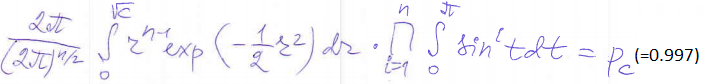  
product of integrals of sin is pi^3 / 6, first term is (2 * pi)^(-2)  
integral of r is 8 - (8 + 4 c + c^2) e^(-c/2)
$$
c=12.766\;(3\;sigma)\\
c=6.68819\;(1\;sigma)
$$

In [4]:
def f(t, x):
    r = np.linalg.norm(x[:3])
    r3 = r**3
    yr = constants.muE / r3
    result = np.empty(6)
    result[0] = x[3]
    result[1] = x[4]
    result[2] = x[5]
    result[3] = -x[0] * yr
    result[4] = -x[1] * yr
    result[5] = -x[2] * yr
    return result


def gen_interpolation(t_points, x_points):
    # t_points must have shape (N,) and x_points must have shape(6, N)
    interpolations = [
        interp1d(t_points,
                 x_points[i, :],
                 kind="cubic",
                 fill_value="extrapolate") for i in range(x_points.shape[0])
    ]

    def x_ref(t):
        return np.array([i(t) for i in interpolations])

    return x_ref


def Jacobian(t, x, mu):
    # R' = V, V' = f(R, t). This Jacobian is df/dx, where x is united R and V
    # Now it is for two-body model
    res = np.empty((3, 6))
    r = np.linalg.norm(x[:3])
    r2 = r**2
    mur3 = mu / r**3

    res[0, 0] = mur3 * (3 * x[0]**2 / r2 - 1)
    res[0, 1] = mur3 * (3 * x[0] * x[1] / r2)
    res[0, 2] = mur3 * (3 * x[0] * x[2] / r2)
    res[0, 3] = 0
    res[0, 4] = 0
    res[0, 5] = 0

    res[1, 0] = mur3 * (3 * x[0] * x[1] / r2)
    res[1, 1] = mur3 * (3 * x[1]**2 / r2 - 1)
    res[1, 2] = mur3 * (3 * x[1] * x[2] / r2)
    res[1, 3] = 0
    res[1, 4] = 0
    res[1, 5] = 0

    res[2, 0] = mur3 * (3 * x[0] * x[2] / r2)
    res[2, 1] = mur3 * (3 * x[1] * x[2] / r2)
    res[2, 2] = mur3 * (3 * x[2]**2 / r2 - 1)
    res[2, 3] = 0
    res[2, 4] = 0
    res[2, 5] = 0
    return res


# Без обезрамзеривания
# def G(t, y, x_ref, mu):
#     # x_ref must be a function returns numpy float array with (6,) shape
#     res = np.empty(6)
#     res[0] = y[3]
#     res[1] = y[4]
#     res[2] = y[5]

#     x = x_ref(t)
#     buf = Jacobian(t, x, mu)
#     res[3:] = np.dot(buf, y)
#     return res

# С обезразмериваниемW[[3, 4, 5], [3, 4, 5]] = V0


def Gu(t, y, x_ref, W, Winv, mu):
    # x_ref must be a function returns numpy float array with (6,) shape
    buf = np.zeros((6, 6))
    buf[[0, 1, 2], [3, 4, 5]] = 1

    x = x_ref(t)
    buf[3:, :] = Jacobian(t, x, mu)
    buf = Winv @ buf @ W

    return np.dot(buf, y)

In [5]:
p0 = constants.aLunar  # in meters
p0km = p0 / 1e3  # in kilometers
V0 = np.sqrt(constants.muE / p0)
W = np.zeros((6, 6))
W[[0, 1, 2], [0, 1, 2]] = p0
W[[3, 4, 5], [3, 4, 5]] = V0
Winv = np.zeros((6, 6))
Winv[[0, 1, 2], [0, 1, 2]] = 1 / p0
Winv[[3, 4, 5], [3, 4, 5]] = 1 / V0

In [6]:
%%time
# Время решать задачу Коши
ref = gen_interpolation(t_eval, res)
dxd0 = []

initial = np.eye(6)  # без обезразмеривания
initial = Winv @ initial  # с обезразмериваниемъ

t_init = 0
t_final = 8 * 24 * 60 * 60
step_max = 10
t_points = np.arange(t_init, t_final + step_max, step_max)

tolerance = 1e-13

Wall time: 155 ms


In [7]:
%%time

# С обезразмериванием
for i in range(initial.shape[1]):
    y0 = initial[:, i]
    dxd0.append(
        solve_ivp(lambda t, y: Gu(t, y, ref, W, Winv, constants.muE),
                  (t_init, t_final),
                  y0,
                  t_eval=t_points,
                  rtol=tolerance,
                  atol=tolerance).y)

# Вариант без обезразмеривания
# for i in range(initial.shape[1]):
#     y0 = initial[:, i]
#         dxd0.append(solve_ivp(lambda t, y: Gu(t, y, ref, W, Winv, constants.muE), (t_init, t_final), y0,
#                           t_eval = t_points, rtol = tolerance, atol = tolerance).y)

# До транспонирования dxd0[i] содержит в себе i-ый столбец матрицы Ф и dxd0[i, j] = Ф[j ,i]
# Поэтому я транспонирую, что бы поменять ориентацию осей на нормальную
dxd0 = np.asarray(dxd0).transpose((1, 0, 2))

Wall time: 972 ms


Нужно провалидировать результаты. Я сравню численное интегрирование и полученное линейное приближение.

In [8]:
# Проверка результатов
# res - номинальная орбита
dV = np.array([0, 0, 0, 0.01, 0, 0])
f0 = res[:, 0] + dV

t0 = 0
tf = 8 * 24 * 60 * 60
step_max = 10
tolerance = 1e-10
t_eval = np.arange(t0, tf + step_max, step_max)

res_new = solve_ivp(f, (t0, tf),
                    f0,
                    t_eval=t_eval,
                    rtol=tolerance,
                    atol=tolerance).y

In [9]:
R_new = res_new[:3, ind]
V_new = res_new[3:, ind]

print(
    " Максимальное различие между изменением координаты в картинной плокости из чилсенного инетгрирования и линейным приближением:\n",
    np.linalg.norm(
        M @ (R_new - res[:3, ind] - np.dot(W @ dxd0[:, :, ind], dV)[:3])),
    "м\n при изменении скорости Vx на",
    np.linalg.norm(dV) * 100, "см/с")

 Максимальное различие между изменением координаты в картинной плокости из чилсенного инетгрирования и линейным приближением:
 0.4265653511001668 м
 при изменении скорости Vx на 1.0 см/с


Точность линейного приближения достаточно хороша. Так же я удостоверился, что правильно решил задачу Коши.  
Теперь преобразую матрицу ковариации.

In [10]:
# матрица f
Mf = dxd0[:, :, ind]
Mfinv = scipy.linalg.inv(Mf)

# Задам матрицу коварииации
K01 = np.zeros((6, 6))
K01[(0, 1, 2), (0, 1, 2)] = (100)**2  # м^2
K01[(3, 4, 5), (3, 4, 5)] = (0.01)**2  # м^2/c^2

In [11]:
K1 = Mf @ K01 @ Mf.T
Kinv1 = Mfinv.T @ scipy.linalg.inv(K01) @ Mfinv
print("Ошибка рассчёта обратной матрицы:",
      np.max(np.abs(K1 @ Kinv1 - np.eye(6))))
Q1 = Kinv1.copy()

c = 12.766  # для n=6 и Pc = 0.997
# c = 2.2407 # для n=3 и Pc = 0.997

Q1 = (Q1 + Q1.T) / 2

Ошибка рассчёта обратной матрицы: 6.964483929783327e-06


Теперь главный вопрос - как спроецировать 6-мерный эллипсоид на плоскость?  
Для начала я перейду к новому базису, в котором координатный базис совпадает с базисом, задающим плоскость.

In [12]:
e11 = np.hstack((e1, [0, 0, 0]))
e22 = np.hstack((e2, [0, 0, 0]))
e33 = np.hstack((e3, [0, 0, 0]))
S = np.eye(6)
S[:, 0] = e11  # матрицы перехода
S[:, 1] = e22
S[:, 2] = e33

Далее эллипс можно представить в виде

Где L - нижняя треугольная матрица из разложения Холецкого, а c = 0 (в нашем случае)

In [13]:
Q1 = S.T @ Q1 @ S  # перехожу к базису, где по координатам базис совпадает с e1, e2, e3
Q1 /= c  # это другая c, она фигурирует в уравнении эллипса xT Q x <= c
L1 = scipy.linalg.cholesky(Q1, lower=True)
print(
    "Абсолютная ошибка рассчёта разложения:", np.max(np.abs((L1 @ L1.T - Q1))),
    "\nУчитывая, что значения в Q1 немаленькие и относительная ошибка меньше e-10"
)

Абсолютная ошибка рассчёта разложения: 1.0 
Учитывая, что значения в Q1 немаленькие и относительная ошибка меньше e-10


Далее задаю оператор проекции на плоскость, d=0
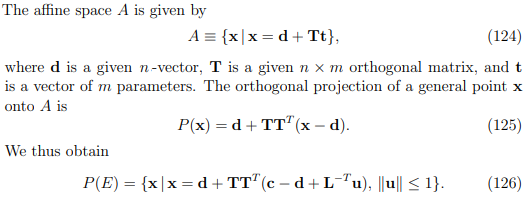

In [14]:
T = np.zeros((6, 2))
T[0, 0] = 1
T[1, 1] = 1
P = T @ T.T

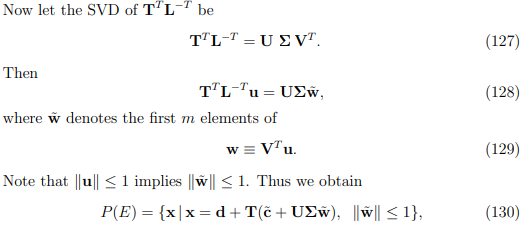

In [15]:
Linv1 = scipy.linalg.inv(L1)
np.max(np.abs(Linv1 @ L1 - np.eye(6)))

2.0004710706935287e-11

In [16]:
buf1 = T.T @ Linv1.T  # MxN
U1, EE1, V1 = scipy.linalg.svd(buf1, full_matrices=False)  # MxM, MxN, NxN
E1 = np.diag(EE1)
np.max(np.abs(buf1 - U1 @ E1 @ V1))

2.168404344971009e-19

И, наконец, считаю матрицу эллипсоида
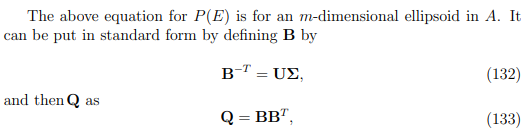

In [17]:
buf1 = scipy.linalg.inv(U1 @ E1).T
QQ1 = buf1 @ buf1.T
np.max(np.abs(buf1.T @ U1 @ E1 - np.eye(2)))

4.1519557591225183e-19

In [18]:
QQ1

array([[ 1.08005066e+06, -1.08432534e+05],
       [-1.08432534e+05,  4.26228341e+08]])

In [19]:
def calc_ellipse(Q, c):
    # Функция для рассчёта канонического вида (и проекции) эллипса, заданного x.T @ Q @ x = c
    # Размер Q либо 3 на 3, и тогда берётся проекция на Оху, либо 2 на 2
    # Возвращает длину главных полуосей a, b и угол v поворота (против часовой) от Ox до оси с полудлинной a

    if Q.shape[0] == 3 and Q.shape[1] == 3:
        A = Q[0, 0] * Q[2, 2] - Q[0, 2]**2
        B = Q[0, 1] * Q[2, 2] - Q[0, 2] * Q[1, 2]
        C = Q[1, 1] * Q[2, 2] - Q[1, 2]**2
        D = c * Q[2, 2]
        A /= D
        B /= D
        C /= D
        D = 1
    elif Q.shape[0] == 2 and Q.shape[1] == 2:
        A = Q[0, 0]
        B = Q[0, 1]
        C = Q[1, 1]
        D = c
        A /= D
        B /= D
        C /= D
        D = 1

    # Если B = 0, то уже в каноническом виде
    if -1e-10 <= B <= -1e-10:
        B = 0
        v = 0
    else:
        # Алгоритм подсмотрен в учебнике Умнова по линейной алгебре
        # Есил A = C
        if C - 1e-10 < A < C + 1e-10:
            A = C
            v = np.pi / 4
        else:
            v = 0.5 * np.arctan(2 * B / (A - C))

    A2 = A * np.cos(v)**2 + B * np.sin(2 * v) + C * np.sin(v)**2
    C2 = A * np.sin(v)**2 - B * np.sin(2 * v) + C * np.cos(v)**2

    a = np.sqrt(1 / A2)
    b = np.sqrt(1 / C2)
    return a, b, v

In [20]:
a, b, v = calc_ellipse(QQ1, 1)
a *= W[0, 0] * 1e-3  # в километры + оразмеривание
b *= W[0, 0] * 1e-3

In [21]:
a, b, v

(370.4624772332061, 18.648313152465548, 0.0002550463621242768)

Построю его на общей картине!

In [22]:
# теперь вспомню, что a и c в метрах, а мне надо в километрах!
B = np.array([Rinf[0], Rinf[1], 0])

x_size = 2 * a
y_size = 2 * b
size = np.max((x_size, y_size))

# Круг - контур Луны (взят средний радиус Луны)
# Moon = plt.Circle((0, 0), constants.RL / 1e3, color = "grey")

# Эллипс рассеяния
ellipse = matplotlib.patches.Ellipse((B[0] / 1e3, B[1] / 1e3),
                                     2 * a,
                                     2 * b,
                                     v * 180 / np.pi,
                                     fill=False,
                                     color="orange",
                                     lw=1.8)

# piercing-point
# pp = plt.Circle((B[0] / 1e3, B[1] / 1e3), np.min((a, b)) / 3, color="red")

# Изолинии. Считаю постоянными Vinf -> h
rps = np.array([rp - 4e5, rp - 2e5, rp, rp + 2e5,
                rp + 4e5])  # высоты для отрисовки
bb = rps * np.sqrt(h + 2 * constants.muL / rps) / Vinf[
    2]  # |Vinf| = Vinf[2] т.к. оно строго вдоль оси e3
cmap = matplotlib.cm.get_cmap('viridis')
n = bb.shape[0]
circles = [
    plt.Circle((0, 0), bb[i] / 1e3, color=cmap(i * 1 / n), fill=False, lw=2)
    for i in range(0, n)
]
# circles = [plt.Circle((0, 0), bb[i]/1e3, color = "black", fill = False) for i in range(0, n)]
patched = PatchCollection(circles, match_original=True)

tau = np.array([B[0] / 1e3, B[1] / 1e3])
tau /= np.linalg.norm(tau)
points_to_annotate = np.array([i / 1e3 * tau for i in bb])
annotations = np.array([
    '{0:,}'.format(decimal.Decimal(int(i / 1e3))).replace(',', ' ')
    for i in (rps - constants.RL)
])
text_coords = np.full(points_to_annotate.shape, (2, 2))

figP, axesP = plt.subplots(1)
figP.set_figheight(8)
figP.set_figwidth(8)

# axesP.add_artist(Moon)

# axesP.add_artist(pp)

axesP.add_artist(ellipse)

axesP.add_collection(patched)

# piercing-point v2
axesP.plot(B[0] / 1e3, B[1] / 1e3, 'o', color = "red", ms = 5)

fs = 24
# axesP.quiver(11600, 110, -1.2, -1.2, color = "red", scale = 0.015, scale_units = 'dots') # для презентации
# axesP.text(11550, 105, 'Moon', fontsize=fs/1.5) # для презентации


axesP.set_xbound((-size + B[0] / 1e3, size + B[0] / 1e3))
# axesP.set_ybound((-size + B[1] / 1e3, size + B[1] / 1e3))
axesP.set_ybound((100, 150)) # для презентации


axesP.set_title("B-plane", fontsize=fs)
axesP.set_xlabel("$\\xi, km$", fontsize=fs)
axesP.set_ylabel("$\eta, km$", fontsize=fs)
axesP.tick_params(axis='both', which='major', labelsize=fs)
axesP.grid(True)

labels = [
    f"{int(i/1e3)//1000} {int(i/1e3)%1000}" for i in (rps - constants.RL)
]
# оно объедает нули! т.е. 8066 пишется как 8 66!
# axesP.legend(circles, labels, title="rp, km", loc=(1.01, 0.5), fontsize=fs)
axesP.legend(circles, labels, title="rp, km", loc=1, fontsize=fs)

# for i in range(annotations.shape[0]):
#     axesP.annotate(annotations[i], xy = points_to_annotate[i], textcoords = 'offset pixels', xytext = text_coords[i])
# pass

# P.S. circles заменить на Arc!!!
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Построение эллипса влияния
$$
Эллипс\;влияния\;-\;отображение\;сферы\;"единичных"\;импульсов\;на\;картинную\;плоскость.\\ 
Пусть\;величина\;единичного\;импульса\;\Delta V\;(например,\;1\;см/с),\;тогда\;сфера\;единичных\;импульсов\;задаётся\;как\;(\Delta\textbf{V}-\;трёхмерный)\\ 
\textbf{E}_{imp}=\{\Delta\textbf{V}|\:\Delta\textbf{V}^T\textbf{Q}_0\:\Delta\textbf{V}\leqslant 1\}=\{\Delta\textbf{V}|\:\Delta\textbf{V}=\textbf{L}_0^{-T}\textbf{w},\:|\textbf{w}|\leqslant 1\}
$$
Где
$$
\textbf{Q}_0=\frac{\textbf{E}}{(\Delta V)^2}=\textbf{L}_0\textbf{L}_0^T\\
\textbf{L}_0=\frac{\textbf{E}}{\Delta V}
$$
Отображение в трёхмерный эллипсоид влияния (проецирование потом!) происходит  
с помощью матрицы частных производных конечных координат по начальной скорости **A**  
и матрицы поворота базиса (в смысле *координат(!)*) **M**
$$
\textbf{y}=\textbf{M}\textbf{A}\:\Delta\textbf{V}\\
\textbf{E}_{corr}=\{\textbf{y}|\:\textbf{y}=\textbf{M}\:\textbf{A}\:\textbf{L}_0^{-T}\textbf{w},\:|\textbf{w}|\leqslant 1\}=\{\textbf{y}|\:\textbf{y}=\textbf{L}_1^{-T}\textbf{w},\:|\textbf{w}|\leqslant 1
$$
Таким образом
$$
\textbf{L}_1^{-T}=\textbf{M}\;\textbf{A}\;\textbf{L}_0^{-T}\\
\textbf{L}_1=\textbf{M}^{-T}\textbf{A}^{-T}\textbf{L}_0\\
\textbf{Q}_1=\textbf{L}_1\textbf{L}_1^T=\textbf{M}^{-T}\textbf{A}^{-T}\textbf{L}_0\textbf{L}_0^T\textbf{A}^{-1}\textbf{M}^{-1} \\
Taking\:into\:account\:\textbf{L}_0=\frac{\textbf{E}}{\Delta V},\:\:\textbf{M}^{-1}=\textbf{M}^T\\
\textbf{Q}_1=\frac{\textbf{M}\textbf{A}^{-T}\textbf{A}^{-1}\textbf{M}^T}{(\Delta V)^2}\\
\textbf{E}_{corr}=\{\textbf{y}|\:\textbf{y}^T\textbf{Q}_1\textbf{y}\leqslant 1\}\\
$$
Получается матрица, задающая 3-мерный эллипсоид, который далее легко проецируется на плоскость.  
  
При рассчёте в обезразмеренных величинах
$$
\textbf{y}=p_0\;\textbf{y'}\\
$$
Где **p**<sub>0</sub> - размерная единица, в данной задаче это большая полуось лунной орбиты (385.000 км)  
Безразмерные координаты, соответствующие нужному эллипсоиду, удовлетворяют соотношению
$$
\textbf{E'}_{corr}=\{\textbf{y'}|\:\textbf{y'}^T\textbf{Q'}_1\textbf{y'}\leqslant 1\}\\
\textbf{Q'}_1 = p_0^2\;\textbf{Q}_1=\frac{\textbf{M}\textbf{A'}^{-T}\textbf{A'}^{-1}\textbf{M}^T}{(\Delta V)^2}\\
\textbf{A'}=\frac{\textbf{A}}{p_0}
$$
Таким образом, все рассчёты можно проводить в безразмерных координатах и лишь при отрисовке переводить это всё в нужные единицы путём домножения на размерную единицу

In [23]:
A = dxd0[:, :, ind][:3, 3:] # обезразмереннное
Vs = 0.1 # в м/с

In [24]:
Ainv = scipy.linalg.inv(A)
np.max(np.abs(A @ Ainv - np.eye(3)))

4.263667512118956e-15

In [25]:
# Задаю матрицу 3D эллипсоида!
Q = M @ Ainv.T @ Ainv @ M.T / Vs**2

In [26]:
# Проецирую на плоскость
a2, b2, v2 = calc_ellipse(Q, 1)
print(a2, b2, v2)
# Я сравнил с результатом проецирования по алогритму, ангалогичному проецированию 6D на 2D
# результат такой же (с точностью до ошибок округления)

0.00033143269842096017 8.002803240492902e-07 0.0002502556890219075


In [27]:
# Для проверки работы алгоритма я переберу все точки из сферы единичных импульсов 
# и посмотрю, как они проецируются на плоскость картинную
points = []
for theta in np.arange(0, np.pi, 0.1):
    for fi in np.arange(0, 2 * np.pi, 0.1):
        points.append(Vs * M @ A @ np.array([np.cos(fi)*np.sin(theta), np.sin(fi)*np.sin(theta), np.cos(theta)]))
points = p0km * np.array(points)

In [28]:
figP2, axesP2 = plt.subplots(1)
figP2.set_figheight(10)
figP2.set_figwidth(10)

ellipse2 = matplotlib.patches.Ellipse((0, 0), 2 * p0km * a2, 2 * p0km * b2, v2 * 180 / np.pi, fill = False, color = "orange", linewidth = 5)

axesP2.add_artist(ellipse2)

axesP2.plot(points[:, 0], points[:, 1])


axesP2.set_title("B-plane, centred at piercing-point")
axesP2.set_xlabel("$\\xi, km$")
axesP2.set_ylabel("$\eta, km$")
axesP2.grid(True)

# Если присмотреться, то видно оранджевый эллипс! Граница синего и оранжевого почти идеально совпадают!!!

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [29]:
# Нарисую эллипсы вместе
B = np.array([Rinf[0], Rinf[1], 0])

x_size = 2 * a
y_size = 2 * b
size = np.max((x_size, y_size))

# Эллипс рассеяния
ellipse = matplotlib.patches.Ellipse((B[0]/1e3, B[1]/1e3), 2 * a, 2 * b, v * 180 / np.pi, fill = False, color = "orange")
ellipse2 = matplotlib.patches.Ellipse((B[0]/1e3, B[1]/1e3), 2 * p0km * a2,
                                      2 * p0km * b2/1e3, v2 * 180 / np.pi, fill = False, color = "black")

# pircing-point
pp = plt.Circle((B[0]/1e3, B[1]/1e3), np.min((a, b))/10, color = "red")

# Изолинии. Считаю постоянными Vinf -> h
rps = np.array([rp - 4e5, rp - 2e5, rp, rp + 2e5, rp + 4e5]) # высоты для отрисовки
bb = rps * np.sqrt(h + 2 * constants.muL / rps) / Vinf[2] # |Vinf| = Vinf[2] т.к. оно строго вдоль оси e3
cmap = matplotlib.cm.get_cmap('viridis')
n = bb.shape[0]
circles = [plt.Circle((0, 0), bb[i]/1e3, color = cmap(i * 1/n), fill = False) for i in range(0, n)]
patched = PatchCollection(circles, match_original = True)

tau = np.array([B[0]/1e3, B[1]/1e3])
tau /= np.linalg.norm(tau)
points_to_annotate = np.array([i/1e3 * tau for i in bb])
annotations = np.array(['{0:,}'.format(decimal.Decimal(int(i/1e3))).replace(',', ' ') for i in (rps - constants.RL)])
text_coords = np.full(points_to_annotate.shape, (2, 2))

figP3, axesP3 = plt.subplots(1)
figP3.set_figheight(10)
figP3.set_figwidth(10)

axesP3.set_xbound((-size + B[0]/1e3, size + B[0]/1e3))
axesP3.set_ybound((-size + B[1]/1e3, size + B[1]/1e3))

axesP3.add_artist(pp)


axesP3.add_artist(ellipse2)

axesP3.add_artist(ellipse)

axesP3.add_collection(patched)


axesP3.set_title("B-plane")
axesP3.set_xlabel("$\\xi, km$")
axesP3.set_ylabel("$\eta, km$")
axesP3.grid(True)

labels = [f"{np.int(i/1e3)//1000} {np.int(i/1e3)%1000}"for i in (rps - constants.RL)] 
#оно объедает нули! т.е. 8066 пишется как 8 66!
axesP3.legend(circles, labels, title = "rp, km", loc=(1.01,0.5))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

<ipython-input-29-920438647200>:52: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = [f"{np.int(i/1e3)//1000} {np.int(i/1e3)%1000}"for i in (rps - constants.RL)]


# Семейство эллипсов влияния
Из решения задачи коши известно
$$
\textbf{Ф}(t)=\textbf{W}\;\textbf{f}(t),\:\textbf{f}(t) = \frac{\partial{\textbf{x'}}}{\partial{\textbf{x}_{0}^{T}}}(t)
$$
Для отрисовки эллипса влияния при проведении коррекции в самом начале необходимо
$$
\textbf{Ф}|_{t_f}=\textbf{W}\frac{\partial{\textbf{x'}}}{\partial{\textbf{x}_{0}^{T}}}|_{t_f}
$$
Для отрисовки эллипса влияния при осуществлении коррекции в какой-либо другой момент времени (**t**<sub>i</sub>) нужно знать
$$
\frac{\partial{\textbf{x}}}{\partial{\textbf{x}_{i}^{T}}}|_{t_f}=
\textbf{W}\frac{\partial{\textbf{x'}}}{\partial{\textbf{x}_{i}^{T}}}|_{t_f}
$$
Найти эти производные можно из:
$$
\frac{\partial{\textbf{x'}}}{\partial{\textbf{x}_{0}^{T}}}=
\frac{\partial{\textbf{x'}}}{\partial{\textbf{x}_{i}^{T}}}\frac{\partial{\textbf{x}_i}}{\partial{\textbf{x}_{0}^{T}}}=
\frac{\partial{\textbf{x'}}}{\partial{\textbf{x}_{i}^{T}}}\textbf{W}\frac{\partial{\textbf{x'}_i}}{\partial{\textbf{x}_0^{T}}}=
\frac{\partial{\textbf{x'}}}{\partial{\textbf{x}_{i}^{T}}}\textbf{W}\frac{\partial{\textbf{x'}}}{\partial{\textbf{x}_0^{T}}}|_{t_i}
$$
Отсюда получается
$$
\frac{\partial{\textbf{x'}}}{\partial{\textbf{x}_{i}^{T}}}=
\frac{\partial{\textbf{x'}}}{\partial{\textbf{x}_{0}^{T}}}\bigg(\frac{\partial{\textbf{x'}}}{\partial{\textbf{x}_0^{T}}}|_{t_i}\bigg)^{-1}\textbf{W}^{-1}\\
\frac{\partial{\textbf{x'}}}{\partial{\textbf{x}_{i}^{T}}}|_{t_f}=\frac{\partial{\textbf{x'}}}{\partial{\textbf{x}_{0}^{T}}}|_{t_f}\bigg(\frac{\partial{\textbf{x'}}}{\partial{\textbf{x}_0^{T}}}|_{t_i}\bigg)^{-1}\textbf{W}^{-1}=\textbf{f}|_{t_f}\textbf{Ф}|_{t_i}^{-1}\\
\textbf{A'}=\frac{\partial{\textbf{x'}}}{\partial{\textbf{x}_{i}^{T}}}|_{t_f}\;[:3,\;3:]\:(upper\:right\:square\:3x3\:submatrix)\\
\textbf{A'}=\frac{\textbf{f}|_{t_f}\textbf{f}|_{t_i}^{-1}\;[:3,\;3:]}{V_0}
$$
Где **V**<sub>0</sub> - размерная единица скорости.  
В результате, решив один раз задачу Коши, можно отрисовывать эллипсы влияния для любого момента коррекции (если, конечно, других коррекций до этого не было)

In [30]:
# рассчитаю эллипс влияния для коррекции посередине полёта
indi = np.int(ind/2)
print("Коррекция через", t_eval[indi], "секунд после начала полёта (всего полёт длится", t_eval[ind], "секунд)")

Коррекция через 133310 секунд после начала полёта (всего полёт длится 266630 секунд)


<ipython-input-30-de29c20449f3>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indi = np.int(ind/2)


In [31]:
ftf = dxd0[:, :, ind]
fti = dxd0[:, :, indi]

ftiinv = scipy.linalg.inv(fti)
# При рассчёте обратной матрицы (W f)^-1 ошибка больше на 5 порядков
np.max(np.abs(fti @ ftiinv - np.eye(6)))

2.7711166694643907e-13

In [32]:
buf = ftf @ ftiinv / V0
Ai = buf[:3, 3:] # обезразмеренные производные координат по скорости, как раз они и нужны

In [33]:
Aiinv = scipy.linalg.inv(Ai)
np.max(np.abs(Ai @ Aiinv - np.eye(3)))
# без обезразмеривания ошибка была e-18 !!

1.1102230246251565e-16

In [34]:
# Задаю матрицу 3D эллипсоида!
Qi = M @ Aiinv.T @ Aiinv @ M.T / Vs**2

In [35]:
# Проецирую на плоскость
a2i, b2i, v2i = calc_ellipse(Qi, 1)
print(a2i, b2i, v2i)

3.6431481414966516e-05 3.327103995542917e-05 -0.0001530659790142329


In [36]:
figPi, axesPi = plt.subplots(1)
figPi.set_figheight(10)
figPi.set_figwidth(10)

ellipsei = matplotlib.patches.Ellipse((0, 0), 2 * p0km * a2i, 2 * p0km * b2i, v2i * 180 / np.pi, fill = False, color = "black")

size = 1.5 * max(p0km * a2i, p0km * b2i)

axesPi.add_artist(ellipsei)

axesPi.set_xbound((-size, size))
axesPi.set_ybound((-size, size))

axesPi.set_title("B-plane, centred at piercing-point")
axesPi.set_xlabel("$\\xi, km$")
axesPi.set_ylabel("$\eta, km$")
axesPi.grid(True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Теперь буду строить семейство эллипсов
Шаг по времени 10 часов

In [37]:
print("Временная сетка задана с шагом", t_eval[1] - t_eval[0], "секунд")
print("Всего лететь", t_eval[-1], "секунд или", round(t_eval[-1]/60/60, 1), "часов")
dt = 10 * 60 * 60
dj = dt//10
print("Поэтому шаг построения эллипса будет", dt//60//60, "часов")

Временная сетка задана с шагом 10 секунд
Всего лететь 691200 секунд или 192.0 часов
Поэтому шаг построения эллипса будет 10 часов


In [38]:
ellipses1 = []
times1 = []
ftf = dxd0[:, :, ind]
Winv = scipy.linalg.inv(W)
# Wftf = W @ ftf # немного оптимизации
for j in range(0, ind, dj):
    ftj = dxd0[:, :, j]
    ftjinv = scipy.linalg.inv(ftj)
    # Aj = (Wftf @ ftjinv @ Winv)[:3, 3:]
    Aj = (ftf @ ftjinv / V0)[:3, 3:]
    Ajinv = scipy.linalg.inv(Aj)
    Qj = M @ Ajinv.T @ Ajinv @ M.T / Vs**2
    ellipses1.append(np.asarray(calc_ellipse(Qj, 1)))
    times1.append(j)
ellipses1 = np.array(ellipses1)

In [39]:
fig, axes = plt.subplots(1)
fig.set_figheight(10)
fig.set_figwidth(10)

xsize1 = p0km * 1.1 * np.max(ellipses1[:, 0])
ysize1 = p0km * 1.1 * np.max(ellipses1[:, 1])


cmap = matplotlib.cm.get_cmap("viridis", ellipses1.shape[0])
els_coll1 = EllipseCollection(2 * p0km * ellipses1[:, 0], 
                             2 * p0km * ellipses1[:, 1], 180/np.pi * ellipses1[:, 2],
                             units = "xy",
                             offsets = np.repeat(np.array([[0, 0]]), ellipses1.shape[0], axis = 0), 
                             edgecolor = cmap.colors, 
                             transOffset = axes.transData,
                             facecolor = "none")

axes.add_collection(els_coll1)

axes.add_collection(els_coll1)

axes.set_xbound((-xsize1, xsize1))
axes.set_ybound((-ysize1, ysize1))

axes.set_title("B-plane, centred at piercing-point")
axes.set_xlabel("$\\xi, km$")
axes.set_ylabel("$\eta, km$")
axes.grid(True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Отдельно построю эллипсы через 0, 10, 30, 60, 120 минут полёта

In [40]:
ellipses2 = []
times2 = []
jj = [60, 3*60, 6*60, 12*60]
for j in jj:
    ftj = dxd0[:, :, j]
    ftjinv = scipy.linalg.inv(ftj)
    Aj = (ftf @ ftjinv / V0)[:3, 3:]
    Ajinv = scipy.linalg.inv(Aj)
    Qj = M @ Ajinv.T @ Ajinv @ M.T / Vs**2
    ellipses2.append(np.asarray(calc_ellipse(Qj, 1)))
    times2.append(j)
ellipses2 = np.array(ellipses2)

In [41]:
fig, axes = plt.subplots(1)
fig.set_figheight(10)
fig.set_figwidth(10)

xsize2 = p0km * 1.1 * np.max(ellipses2[:, 0])
ysize2 = p0km * 1.1 * np.max(ellipses2[:, 1])

cmap = matplotlib.cm.get_cmap("viridis", ellipses2.shape[0])
els_coll2 = EllipseCollection(2 * p0km * ellipses2[:, 0], 
                             2 * p0km * ellipses2[:, 1], 180/np.pi * ellipses2[:, 2],
                             units = "xy",
                             offsets = np.repeat(np.array([[0, 0]]), ellipses2.shape[0], axis = 0),
                             edgecolors = cmap.colors, 
                             transOffset = axes.transData,
                             facecolor = "none")

axes.add_collection(els_coll2)

axes.set_xbound((-xsize2, xsize2))
axes.set_ybound((-ysize2, ysize2))

axes.set_title("B-plane, centred at piercing-point")
axes.set_xlabel("$\\xi, km$")
axes.set_ylabel("$\eta, km$")
axes.grid(True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Теперь вместе

In [42]:
fig, axes = plt.subplots(1)
fig.set_figheight(8)
fig.set_figwidth(8)

xsize = max(xsize1, xsize2)
ysize = max(ysize1, ysize2)

# matplotlib.collections.EllipseCollection(widths, heights, angles, units='points', **kwargs)

els = np.vstack((ellipses2, ellipses1[1:])) # [1:] потому что есть повторение по первому элементу
times = np.hstack((times2, times1[1:]))

cmap = matplotlib.cm.get_cmap("viridis", els.shape[0])
els_coll = EllipseCollection(2 * p0km * els[:, 0], 
                             2 * p0km * els[:, 1], 180/np.pi * els[:, 2],
                             units = "xy",
                             offsets = np.repeat(np.array([[0, 0]]), els.shape[0], axis = 0), 
                             edgecolor = cmap.colors, 
                             transOffset = axes.transData,
                             facecolor = "none",
                             lw=2)

axes.add_collection(els_coll)

fs = 24
labels = [f'{i/3600:0.2f}' for i in times]
l = axes.legend([plt.plot([],ls="-", color=c)[0] for c in cmap.colors], labels, loc=1, fontsize=fs)
l.set_title("Fly time, hours", prop = {"size": 24})

axes.set_xbound((-xsize, xsize))
axes.set_ybound((-ysize, ysize))
axes.tick_params(axis='both', which='major', labelsize=fs)

axes.set_title("B-plane, centred at piercing-point", fontsize=fs)
axes.set_xlabel("$\\xi, km$", fontsize=fs)
axes.set_ylabel("$\eta, km$", fontsize=fs)
axes.grid(True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …